## The request input part
First experiment with 50 requests in total, 4 requests were rejected (not enqueued) 
With a probability of appr. 70% + 10%, user 2 requests arrived. The rest was left to users 0 and 1.
```
double rNum = random.nextDouble();
if (rNum > 0.3) {                               # 70% user 2
    user = new User(2, ++cnt);
else
    user = new User(random.nextInt(3), ++cnt);  # 10% user 2
```

# TODO:
## 1. Try without cutting off with rejected policy
## 2. increase q_swap factor, so to favor fast q

In [17]:
import numpy as np
import matplotlib.pyplot as plt

### This is a legend to the data in the csv files:

In [18]:
# IN,  1,     2,1852440846143583, 0,    1,         1
#
#  0,  1  ,   2  ,   3    ,   4   ,     5    ,     6
#
# IN, round, UID, arriTime, deqTime, prioQed,  requestID

#
#prioQed legend:
# F ---> 0    #Fast Queue
# S ---> 1    #Slow Queue
# R ---> 2    #Rejected (not enqueued)

In [19]:
# import csv data TODO

#exp_no = 1
#Exp1: 50 req
#rNum > 0.3 for user 2 and user = new User(random.nextInt(3), ++cnt); for the user 0 and 1 AND 2 also!!
#data_all = np.genfromtxt("sorted_log.2024-08-22T23:20:00.212427.csv", delimiter=',')

#exp_no = 2
#Exp2: 50 req
#rNum > 0.5 for user 2 and user = new User(random.nextInt(2!!!not 3), ++cnt); for the user 0 and 1
#data_all = np.genfromtxt("sorted_exp2_log.2024-08-29T17:07:01.272412.csv", delimiter=',')

#exp_no = 3
#Exp3: 500 req
#rNum > 0.3 for user 2 and user = new User(random.nextInt(3), ++cnt); for the user 0 and 1 AND 2 also!!
#PENALTY_LIMIT = REQUEST_COUNT_LIMIT + 50; //was @ 10
#REQUEST_COUNT_LIMIT = 30 //was 5
#data_all = np.genfromtxt("sorted_exp3_log.2024-08-29T18:56:19.FS_no_R.csv", delimiter=',')

exp_no = 4
#Exp4: 500 req no rejected policy
#rNum > 0.3 for user 2 and user = new User(random.nextInt(3), ++cnt); for the user 0 and 1 AND 2 also!!
#PENALTY_LIMIT = REQUEST_COUNT_LIMIT + infinity; //was @ 10
#REQUEST_COUNT_LIMIT = 30 //was 5
data_all = np.genfromtxt("sorted_exp4_log.2024-09-04T12:49:21.csv", delimiter=',')





In [20]:
#num_rejected = [ i for i in range(len(data_all)) if data_all[i, 5] == "F"]
num_rejected = 0
for i in range(len(data_all)):
    if data_all[i, 5] == 2:
        num_rejected += 1
num_rejected

0

In [21]:
with_rejected = False
arri_dq_t = 3   # 3 is cv index for arriTime and 4 is deqTime
UID = 2         #2 is csv index for user id
q_type = 5     # 5 is csv index for the q type (fast, slow, 'rejected')

total_requests = 500

csv_row_upper = 0
if with_rejected:
    csv_row_lower = total_requests - 1
else:
    csv_row_lower = (len(data_all) // 2) -1
total_time_IN =  data_all[csv_row_lower, arri_dq_t] - data_all[csv_row_upper, arri_dq_t]

total_time_IN, csv_row_lower, data_all[csv_row_lower,arri_dq_t], data_all[csv_row_upper, arri_dq_t]

(206914688.0, 499, 521888535325619.0, 521888328410931.0)

In [22]:
amount_intervals = 14
time_interval = total_time_IN / amount_intervals
time_interval

14779620.57142857

In [23]:
in_secs = time_interval / 1E9
in_ms = time_interval / 1E6
print("time_interval: \n{} s\n{} ms".format(in_secs.round(3), in_ms.round(3)))
print
print("Total time for enqueueing: \n{} s\n{} ms".format(round((total_time_IN / 1E9),3), round((total_time_IN / 1E6),3)))

time_interval: 
0.015 s
14.78 ms
Total time for enqueueing: 
0.207 s
206.915 ms


In [24]:
len_all = len(data_all)
len_clean = len_all - num_rejected
len_OUT_part = (len_clean // 2)
len_IN_part = csv_row_lower + 1 
len_all, len_clean, len_IN_part, len_OUT_part

(1000, 1000, 500, 500)

In [69]:
arr0 = np.zeros([amount_intervals])
arr1 = np.zeros([amount_intervals])
arr2 = np.zeros([amount_intervals])
arr3 = np.zeros([amount_intervals]) # number of rejected array
upper_idx = len_IN_part // amount_intervals
lower_bound = data_all[csv_row_upper, arri_dq_t]

for k in range(1, amount_intervals + 2): # exceed num of intervals to obtain the latest dequeue time
    arr_idx = k
    if ((k * upper_idx)) > (len_IN_part - 1): # set upper_bound to latest dequeue time
        upper_bound = data_all[(len_IN_part -1), arri_dq_t]
        arr_idx = amount_intervals
    else:
        upper_bound = data_all[((k * upper_idx)), arri_dq_t] # everything below the latest deQ time
    print(k)   
    print(((k * upper_idx)))
    print(upper_bound)
    for i in range(len_IN_part):
        time = data_all[i, arri_dq_t]
        #print(i, lower_bound, time, upper_bound)
        if k < amount_intervals:
            cond1 = (lower_bound <= time < upper_bound)
        else:
            cond1 = (lower_bound <= time <= upper_bound) #include requests that came latest, too.
        if cond1:  
            match data_all[i,UID]:
                case 0:
                    if data_all[i,q_type] == 2: # q_type 2 == rejected
                        arr3[arr_idx - 1] += 1
                        continue
                    arr0[arr_idx - 1] += 1
                case 1:
                    if data_all[i,q_type] == 2:
                        arr3[arr_idx - 1] += 1
                        continue
                    arr1[arr_idx - 1] += 1
                case 2:
                    if data_all[i,q_type] == 2:
                        arr3[arr_idx - 1] += 1
                        continue
                    arr2[arr_idx - 1] += 1
    lower_bound = upper_bound
    #print("--------")
    
arr0.sum(), arr1.sum(), arr2.sum(),arr3.sum(),arr0, arr1, arr2, arr3, arr0.sum()+ arr1.sum()+ arr2.sum()
        

521888328410931.0
1
35
521888355081829.0
2
70
521888369195876.0
3
105
521888386233037.0
4
140
521888397428480.0
5
175
521888407932786.0
6
210
521888415824114.0
7
245
521888435188938.0
8
280
521888475929598.0
9
315
521888487507373.0
10
350
521888497803269.0
11
385
521888505890925.0
12
420
521888511737510.0
13
455
521888519498726.0
14
490
521888532470205.0
15
525
521888535325619.0


(41.0,
 50.0,
 410.0,
 0.0,
 array([3., 1., 4., 2., 5., 2., 2., 1., 3., 1., 4., 4., 5., 4.]),
 array([6., 3., 3., 0., 1., 4., 1., 7., 5., 9., 5., 2., 0., 4.]),
 array([26., 31., 28., 33., 29., 29., 32., 27., 27., 25., 26., 29., 30.,
        38.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 501.0)

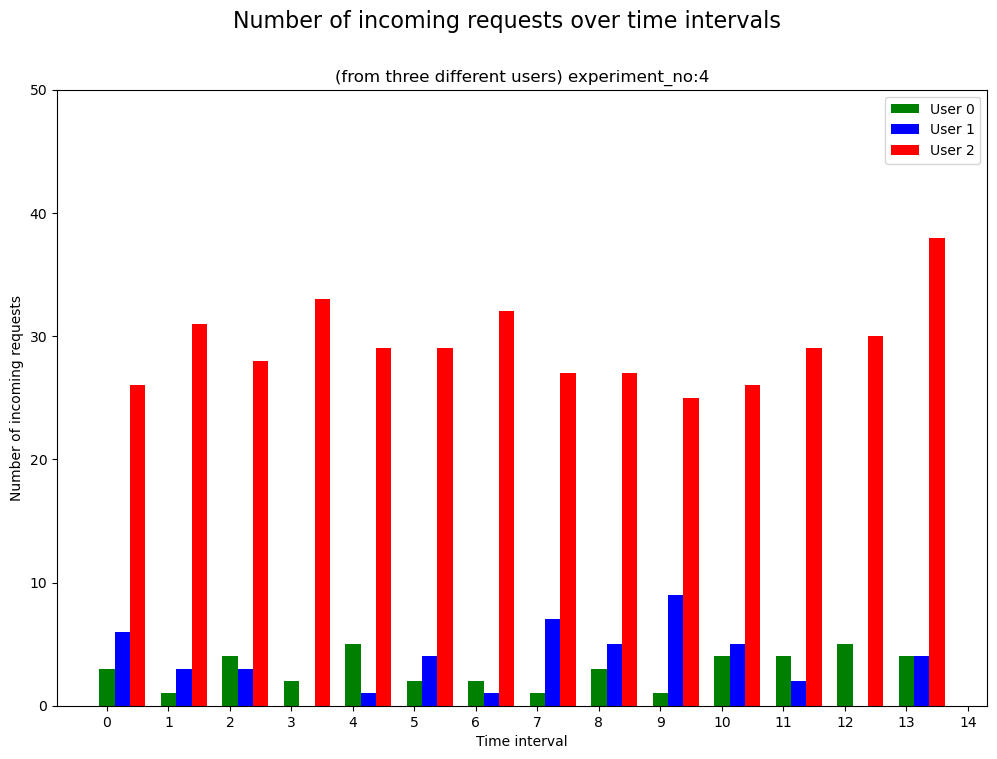

(41.0,
 50.0,
 410.0,
 0.0,
 array([3., 1., 4., 2., 5., 2., 2., 1., 3., 1., 4., 4., 5., 4.]),
 array([6., 3., 3., 0., 1., 4., 1., 7., 5., 9., 5., 2., 0., 4.]),
 array([26., 31., 28., 33., 29., 29., 32., 27., 27., 25., 26., 29., 30.,
        38.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [72]:

x = [i for i in range(amount_intervals)]
width=0.25
#alpha=0.5
ax = plt.figure(figsize=[12, 8])
plt.bar(np.arange(len(arr0)) ,arr0, width,align='center', label='User 0' , color='g')
plt.bar(np.arange(len(arr1)) + width ,arr1, width, align='center',  label='User 1', color='b')
plt.bar(np.arange(len(arr2)) + width*2,arr2, width,align='center',label='User 2' , color='r')
#plt.bar(np.arange(len(arr3)) + width*3,arr3, width,align='center',label='Rejected' , color='black')
plt.xlabel('Time interval')
plt.ylabel('Number of incoming requests')
plt.suptitle('Number of incoming requests over time intervals', fontsize=16)#, y=1.00)
plt.title('(from three different users) experiment_no:{}'.format(exp_no))
plt.ylim(0,50)
plt.xticks(np.arange(len(x)+ width))
plt.legend()

plt.show()

arr0.sum(),arr1.sum(),arr2.sum(),arr3.sum(),arr0, arr1, arr2, arr3

In [64]:
for i in range(1, amount_intervals + 2):
    a = i * (500 // amount_intervals)
    print(i, a)

1 35
2 70
3 105
4 140
5 175
6 210
7 245
8 280
9 315
10 350
11 385
12 420
13 455
14 490
15 525
